## ref : https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 7]

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip
/kaggle/input/nyc-taxi-trip-duration/test.zip
/kaggle/input/nyc-taxi-trip-duration/train.zip
/kaggle/input/new-york-city-taxi-with-osrm/fastest_routes_test.csv
/kaggle/input/new-york-city-taxi-with-osrm/accidents_2016.csv
/kaggle/input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv
/kaggle/input/new-york-city-taxi-with-osrm/second_fastest_routes_train.csv
/kaggle/input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv
/kaggle/input/new-york-city-taxi-with-osrm/second_fastest_routes_test.csv
/kaggle/input/new-york-city-taxi-with-osrm/test.csv
/kaggle/input/new-york-city-taxi-with-osrm/train.csv


## Data understanding

In [2]:
train = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/train.zip')
test = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/test.zip')
sample_submission = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip')

print('shape of train :', train.shape)
print('shape of test  :', test.shape)

display(train.head(2))
display(test.head(2))

shape of train : (1458644, 11)
shape of test  : (625134, 9)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N


- columns 'dropoff_datetime' and 'trip_duration' are only available for the train set.

In [3]:
print('id is unique') if train['id'].nunique() == train.shape[0] else print('oops')
print('Train and Test sets are distinct') if np.intersect1d( train.id, test.id ).shape[0] == 0 else print('oops')
print('No missing values') if train.isna().sum().sum()==0 and test.isna().sum().sum()==0 else print('oops')
print()

print('Unique values of store_and_fwd_flag col :',
       set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))
print('Min Trip duration (in sec)  :', train.trip_duration.min())
print('Max Trip duration (in hour) :', train.trip_duration.max() // 3600)

id is unique
Train and Test sets are distinct
No missing values

Unique values of store_and_fwd_flag col : {'N', 'Y'}
Min Trip duration (in sec)  : 1
Max Trip duration (in hour) : 979


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## Converting datatype & Adding new features

In [5]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

train['pickup_date'] = train['pickup_datetime'].dt.date
test['pickup_date'] = test['pickup_datetime'].dt.date

train['store_and_fwd_flag'] = (train['store_and_fwd_flag'] == 'Y') * 1
test['store_and_fwd_flag'] = (test['store_and_fwd_flag'] == 'Y') * 1

train['log_trip_duration'] = np.log1p(train.trip_duration)
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x : x.total_seconds())
print('Trip duration and datetimes are ok') if (np.abs(train['check_trip_duration'] - train['trip_duration']) > 1).sum() == 0 else print('oops')

Trip duration and datetimes are ok


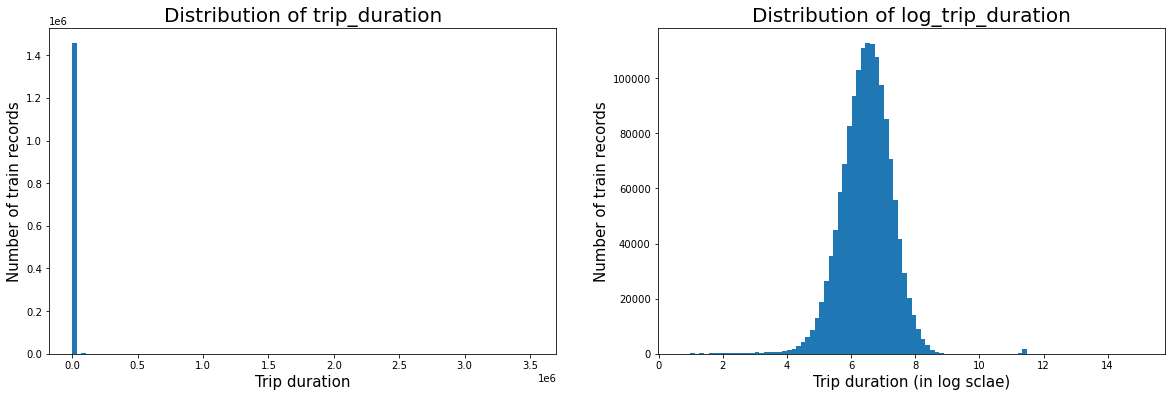

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].hist(train['trip_duration'], bins=100)
ax[0].set_title('Distribution of trip_duration', size=20)
ax[0].set_xlabel('Trip duration', size=15)
ax[0].set_ylabel('Number of train records', size=15)

ax[1].hist(train['log_trip_duration'], bins=100)
ax[1].set_title('Distribution of log_trip_duration', size=20)
ax[1].set_xlabel('Trip duration (in log sclae)', size=15)
ax[1].set_ylabel('Number of train records', size=15)
plt.show()

## Validation Strategy
- Let's check the train test split. It helps to decide validation strategy and gives ideas about feature engineering.

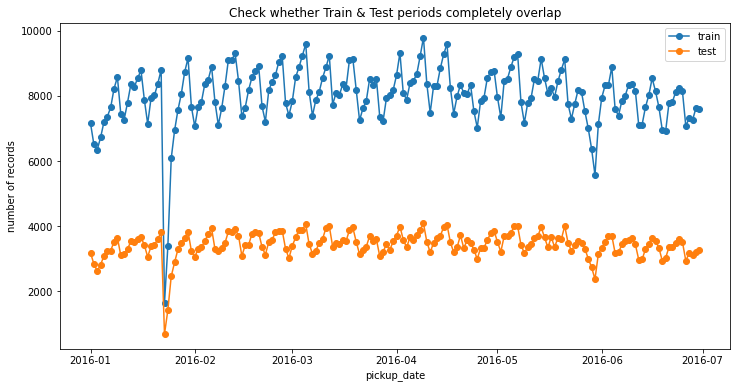

In [7]:
plt.figure(figsize=(12, 6))
train.groupby('pickup_date')['id'].count().plot(style='-o', label='train')
test.groupby('pickup_date')['id'].count().plot(style='-o', label='test')
plt.title('Check whether Train & Test periods completely overlap')
plt.ylabel('number of records')
plt.legend()
plt.show()

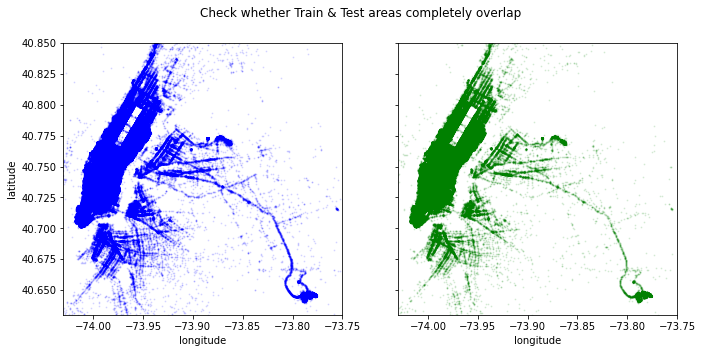

In [8]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(1, 2, figsize=(11, 5), sharex=True, sharey=True)
plt.suptitle('Check whether Train & Test areas completely overlap')

ax[0].scatter(train.pickup_longitude, train.pickup_latitude, color='blue', s=1, alpha=0.1)
ax[1].scatter(test.pickup_longitude, test.pickup_latitude, color='green', s=1, alpha=0.1)

plt.xlim(city_long_border)
plt.ylim(city_lat_border)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
plt.show()

- In this case the train and test split seems to be random. This allows us to use unsupervised learning and feature extraction to be applied on the full data set.

## Feature Extraction 1. PCA
Here, I use PCA to transform longitude and latitude. It's not about demension reduction since I transform 2D → 2D. The rotation could help for decision tree splits.

In [9]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                     test[['pickup_latitude', 'pickup_longitude']].values,
                     test[['dropoff_latitude', 'dropoff_longitude']].values))
pca = PCA().fit(coords)


train['pickup_pca0']  = pca.transform(train[['pickup_latitude', 'pickup_longitude']].values)[:, 0]
train['pickup_pca1']  = pca.transform(train[['pickup_latitude', 'pickup_longitude']].values)[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']].values)[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']].values)[:, 1]

test['pickup_pca0']  = pca.transform(test[['pickup_latitude', 'pickup_longitude']].values)[:, 0]
test['pickup_pca1']  = pca.transform(test[['pickup_latitude', 'pickup_longitude']].values)[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']].values)[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']].values)[:, 1]

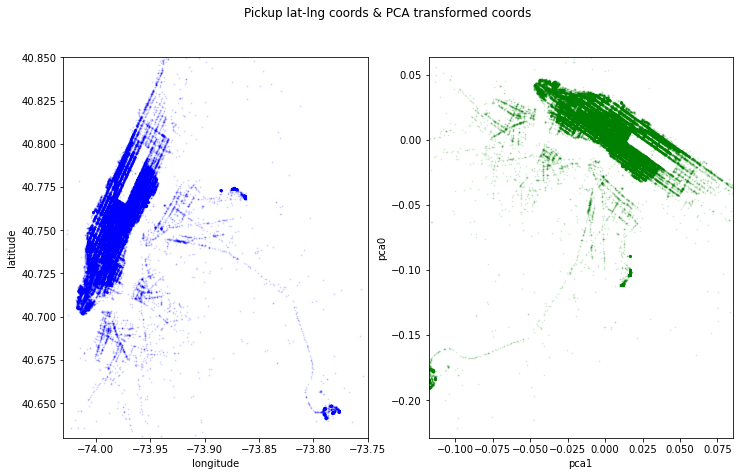

In [10]:
fig, ax = plt.subplots(1, 2)

ax[0].scatter(train['pickup_longitude'].values[:100000],
              train['pickup_latitude'].values[:100000],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca1'].values[:100000],
              train['pickup_pca0'].values[:100000],
              color='green', s=1, alpha=0.1)

fig.suptitle('Pickup lat-lng coords & PCA transformed coords')

ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)

pca_borders = pca.transform([[y, x] for y, x in zip(city_lat_border, city_long_border)])
pca1_border = pca_borders[:, 1]
pca0_border = pca_borders[:, 0]
ax[1].set_xlabel('pca1')
ax[1].set_ylabel('pca0')
ax[1].set_xlim(pca1_border.min(), pca1_border.max())
ax[1].set_ylim(pca0_border.min(), pca0_border.max())

plt.show()

## Feature Extraction 2. Distance, Bearing
- Trip Distance is the distance(km) between pickup and dropoff points. Currently haversine is used, but geopy has another heuristics. Since the cabs are not flying, it's also reasonable to check the Manhattan(L1) distance, too.
- I also extract the bearing between pickup and dropoff points.

In [11]:
def haversine_array(lat1, lng1, lat2, lng2):
    avg_earth_radius = 6371  # in km
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5)**2
    h = 2 * avg_earth_radius * np.arcsin(np.sqrt(d))
    return h


def dummy_manhattan_dist(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a+b


def bearing_array(lat1, lng1, lat2, lng2):
    avg_earth_radius = 6371
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


train['distance_haversine'] = haversine_array(train['pickup_latitude'], train['pickup_longitude'],
                                              train['dropoff_latitude'], train['dropoff_longitude'])
train['distance_dummy_manhattan'] = dummy_manhattan_dist(train['pickup_latitude'], train['pickup_longitude'],
                                                         train['dropoff_latitude'], train['dropoff_longitude'])
train['direcction'] = bearing_array(train['pickup_latitude'], train['pickup_longitude'],
                                    train['dropoff_latitude'], train['dropoff_longitude'])
train['pca_manhattan'] = np.abs(train['dropoff_pca0'] - train['pickup_pca0']) +\
                            np.abs(train['dropoff_pca1'] - train['pickup_pca1'])
train['center_lat'] = (train['pickup_latitude'] + train['dropoff_latitude'])/2
train['center_lng'] = (train['pickup_longitude'] + train['dropoff_longitude'])/2


test['distance_haversine'] = haversine_array(test['pickup_latitude'], test['pickup_longitude'],
                                             test['dropoff_latitude'], test['dropoff_longitude'])
test['distance_dummy_manhattan'] = dummy_manhattan_dist(test['pickup_latitude'], test['pickup_longitude'],
                                                        test['dropoff_latitude'], test['dropoff_longitude'])
test['direcction'] = bearing_array(test['pickup_latitude'], test['pickup_longitude'],
                                   test['dropoff_latitude'], test['dropoff_longitude'])
test['pca_manhattan'] = np.abs(test['dropoff_pca0'] - test['pickup_pca0']) +\
                            np.abs(test['dropoff_pca1'] - test['pickup_pca1'])
test['center_lat'] = (test['pickup_latitude'] + test['dropoff_latitude'])/2
test['center_lng'] = (test['pickup_longitude'] + test['dropoff_longitude'])/2


print(train.shape, test.shape)
train.head(3)

(1458644, 24) (625134, 20)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,distance_haversine,distance_dummy_manhattan,direcction,pca_manhattan,center_lat,center_lng
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,0.007691,0.017053,-0.009666,0.013695,1.498521,1.735433,99.970196,0.020716,40.766769,-73.973392
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,0.007677,-0.012371,0.027145,-0.018652,1.805507,2.430506,-117.153768,0.025749,40.734858,-73.989948
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,0.004803,0.012879,0.034222,-0.039337,6.385098,8.203575,-159.680165,0.081636,40.737013,-73.992180


## Feature Extraction 3. Datetime features

In [12]:
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_minute'] = train['pickup_datetime'].dt.minute
train['pickup_nth_sec'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train['pickup_hourofweek'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_minute'] = test['pickup_datetime'].dt.minute
test['pickup_nth_sec'] = (test['pickup_datetime'] - test['pickup_datetime'].min()).dt.total_seconds()
test['pickup_hourofweek'] = test['pickup_weekday'] * 24 + test['pickup_hour']


print(train.shape, test.shape)
train.head(3)

(1458644, 30) (625134, 26)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,direcction,pca_manhattan,center_lat,center_lng,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_nth_sec,pickup_hourofweek
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,99.970196,0.020716,40.766769,-73.973392,0,11,17,24,6369878.0,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,-117.153768,0.025749,40.734858,-73.989948,6,23,0,43,14085798.0,144
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,-159.680165,0.081636,40.737013,-73.992180,1,3,11,35,1596907.0,35


## Feature Extraction 4. Speed
The speed of each trip is trip distance divided by trip duration. It can be calculated **only in train dataset** since trip duration is only in train dataset.

In [13]:
train['avg_speed_haversine'] = train['distance_haversine'] / train['trip_duration'] * 1000
train['avg_speed_manhattan'] = train['distance_dummy_manhattan'] / train['trip_duration'] * 1000

# round up lat-lng for visualization
train['pickup_lat_bin'] = train['pickup_latitude'].round(3)
train['pickup_lng_bin'] = train['pickup_longitude'].round(3)


print(train.shape, test.shape)
train.head(3)

(1458644, 34) (625134, 26)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_nth_sec,pickup_hourofweek,avg_speed_haversine,avg_speed_manhattan,pickup_lat_bin,pickup_lng_bin
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,0,11,17,24,6369878.0,17,3.293452,3.814139,40.768,-73.982
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,6,23,0,43,14085798.0,144,2.723239,3.665922,40.739,-73.980
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,1,3,11,35,1596907.0,35,3.006167,3.862323,40.764,-73.979


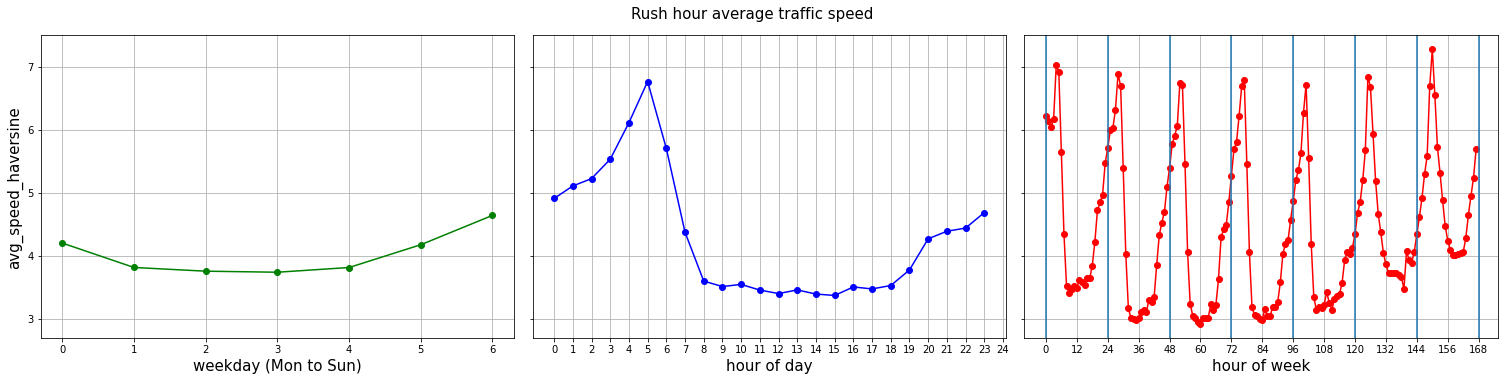

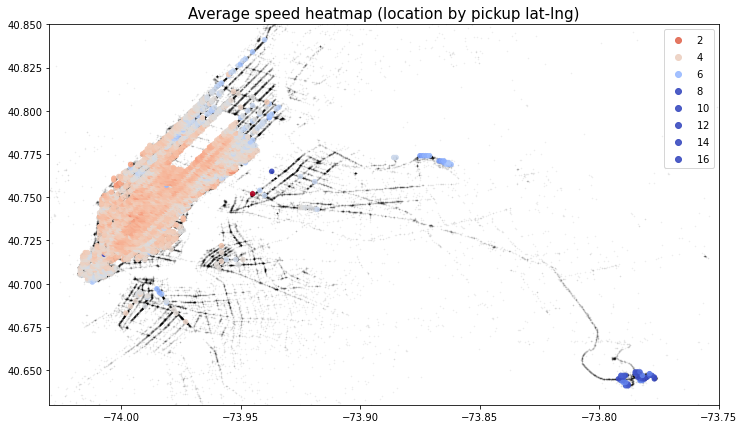

In [14]:
# Visualize avg_speed_haversine by datetime features
fig, ax = plt.subplots(1, 3, figsize=(21, 5), sharey=True)
ax[0].set_ylabel('avg_speed_haversine', size=15)

ax[0].plot(train.groupby('pickup_weekday')['avg_speed_haversine'].mean(), 'g-o')
ax[0].set_xlabel('weekday (Mon to Sun)', size=15)
ax[0].grid()

ax[1].plot(train.groupby('pickup_hour')['avg_speed_haversine'].mean(), 'b-o')
ax[1].set_xlabel('hour of day', size=15)
ax[1].set_xticks(range(0, 25))
ax[1].grid()

ax[2].plot(train.groupby('pickup_hourofweek')['avg_speed_haversine'].mean(), 'r-o')
ax[2].set_xlabel('hour of week', size=15)
ax[2].set_xticks(range(0, 24*7+1, 12))
ax[2].grid()
    
for i in range(0, 24*7+1, 24):
    ax[2].axvline(i)

plt.suptitle('Rush hour average traffic speed', size=15, y=1.05)
plt.tight_layout()
plt.show()



# Average speed for regions
coord_speed = train.groupby(['pickup_lat_bin', 'pickup_lng_bin'])['avg_speed_haversine'].mean().reset_index()
coord_count = train.groupby(['pickup_lat_bin', 'pickup_lng_bin'])['id'].count().reset_index()
coord_stats = coord_speed.merge(coord_count, on=['pickup_lat_bin', 'pickup_lng_bin'])
coord_stats = coord_stats[coord_stats.id>100]

# Visualize Average speed for regions
plt.scatter(train.loc[:1000000, 'pickup_longitude'], train.loc[:1000000, 'pickup_latitude'],
            c='k', s=0.5, alpha=0.05)
scatter = plt.scatter(coord_stats['pickup_lng_bin'], coord_stats['pickup_lat_bin'],
                      c=coord_stats['avg_speed_haversine'], cmap='coolwarm_r',
                      s=20, alpha=0.9, vmin=1, vmax=8)

plt.xlim(city_long_border)
plt.ylim(city_lat_border)

plt.title('Average speed heatmap (location by pickup lat-lng)', size=15)
plt.legend(*scatter.legend_elements(), loc='upper right')
plt.show()

## Feature Extraction 5. lat-lng bin, pickup_nth_sec_bin bin

In [15]:
train['pickup_lat_bin'] = train['pickup_latitude'].round(2)
train['pickup_lng_bin'] = train['pickup_longitude'].round(2)
train['center_lat_bin'] = train['center_lat'].round(2)
train['center_lng_bin'] = train['center_lng'].round(2)
train['pickup_nth_sec_bin'] = train['pickup_nth_sec'] // (3*3600)

test['pickup_lat_bin'] = test['pickup_latitude'].round(2)
test['pickup_lng_bin'] = test['pickup_longitude'].round(2)
test['center_lat_bin'] = test['center_lat'].round(2)
test['center_lng_bin'] = test['center_lng'].round(2)
test['pickup_nth_sec_bin'] = test['pickup_nth_sec'] // (3*3600)


print(train.shape, test.shape)
train.head(3)

(1458644, 37) (625134, 31)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_minute,pickup_nth_sec,pickup_hourofweek,avg_speed_haversine,avg_speed_manhattan,pickup_lat_bin,pickup_lng_bin,center_lat_bin,center_lng_bin,pickup_nth_sec_bin
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,24,6369878.0,17,3.293452,3.814139,40.77,-73.98,40.77,-73.97,589.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,43,14085798.0,144,2.723239,3.665922,40.74,-73.98,40.73,-73.99,1304.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,35,1596907.0,35,3.006167,3.862323,40.76,-73.98,40.74,-73.99,147.0


## Feature Extraction 6. Clustering

In [16]:
%%time
# sample_idx = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords)

train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

print(train.shape, test.shape)
train.head(3)

(1458644, 39) (625134, 33)
CPU times: user 13.5 s, sys: 761 ms, total: 14.2 s
Wall time: 4.28 s


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hourofweek,avg_speed_haversine,avg_speed_manhattan,pickup_lat_bin,pickup_lng_bin,center_lat_bin,center_lng_bin,pickup_nth_sec_bin,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,17,3.293452,3.814139,40.77,-73.98,40.77,-73.97,589.0,75,23
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,144,2.723239,3.665922,40.74,-73.98,40.73,-73.99,1304.0,57,24
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,35,3.006167,3.862323,40.76,-73.98,40.74,-73.99,147.0,8,46


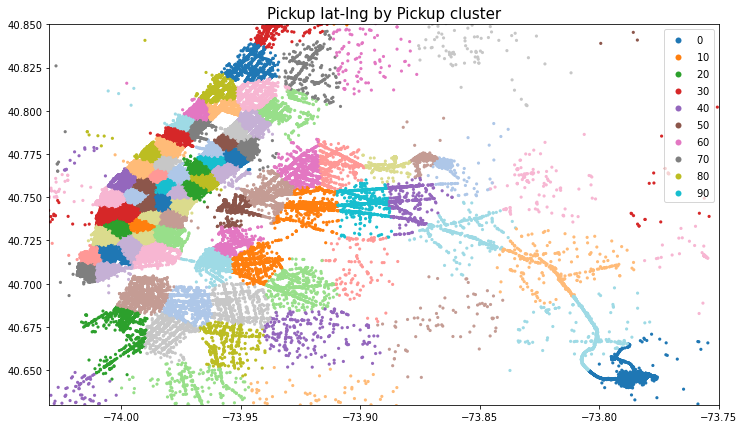

In [17]:
scatter = plt.scatter(train.pickup_longitude[:1000000], train.pickup_latitude[:1000000],
                      c=train.pickup_cluster[:1000000], s=10, lw=0, cmap='tab20')

plt.title('Pickup lat-lng by Pickup cluster', size=15)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.legend(*scatter.legend_elements(), loc='upper right')
plt.show()

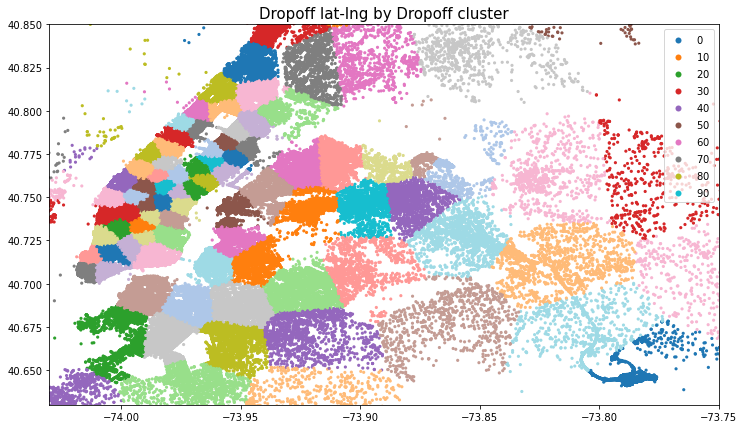

In [18]:
scatter = plt.scatter(train.dropoff_longitude[:1000000], train.dropoff_latitude[:1000000],
                      c=train.dropoff_cluster[:1000000], s=10, lw=0, cmap='tab20')

plt.title('Dropoff lat-lng by Dropoff cluster', size=15)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.legend(*scatter.legend_elements(), loc='upper right')
plt.show()